In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def imshow(image):
    cv.imshow('image', image)
    cv.waitKey(0) 
    cv.destroyWindow('image')

### Image gradients

Расшерение понятия производной для изображений дает нам все те же возможности, которые мы используем в математике. Самый простой пример - самый простой  
алгоритм поиска углов завязан на резком перепаде производной в точках угла. 

#### Sobel Derivative

Производная по Собелю - простая штука  

![Sobel](./info/Sobel.png)

Здесь "*" это свертка. Так что на деле это просто свертка с фиксированным ядром.
Поскольку производная по x и y различна их можно незатейливо скомбинировать и получить магнитуду

![Sobel2](./info/Sobel2.png)

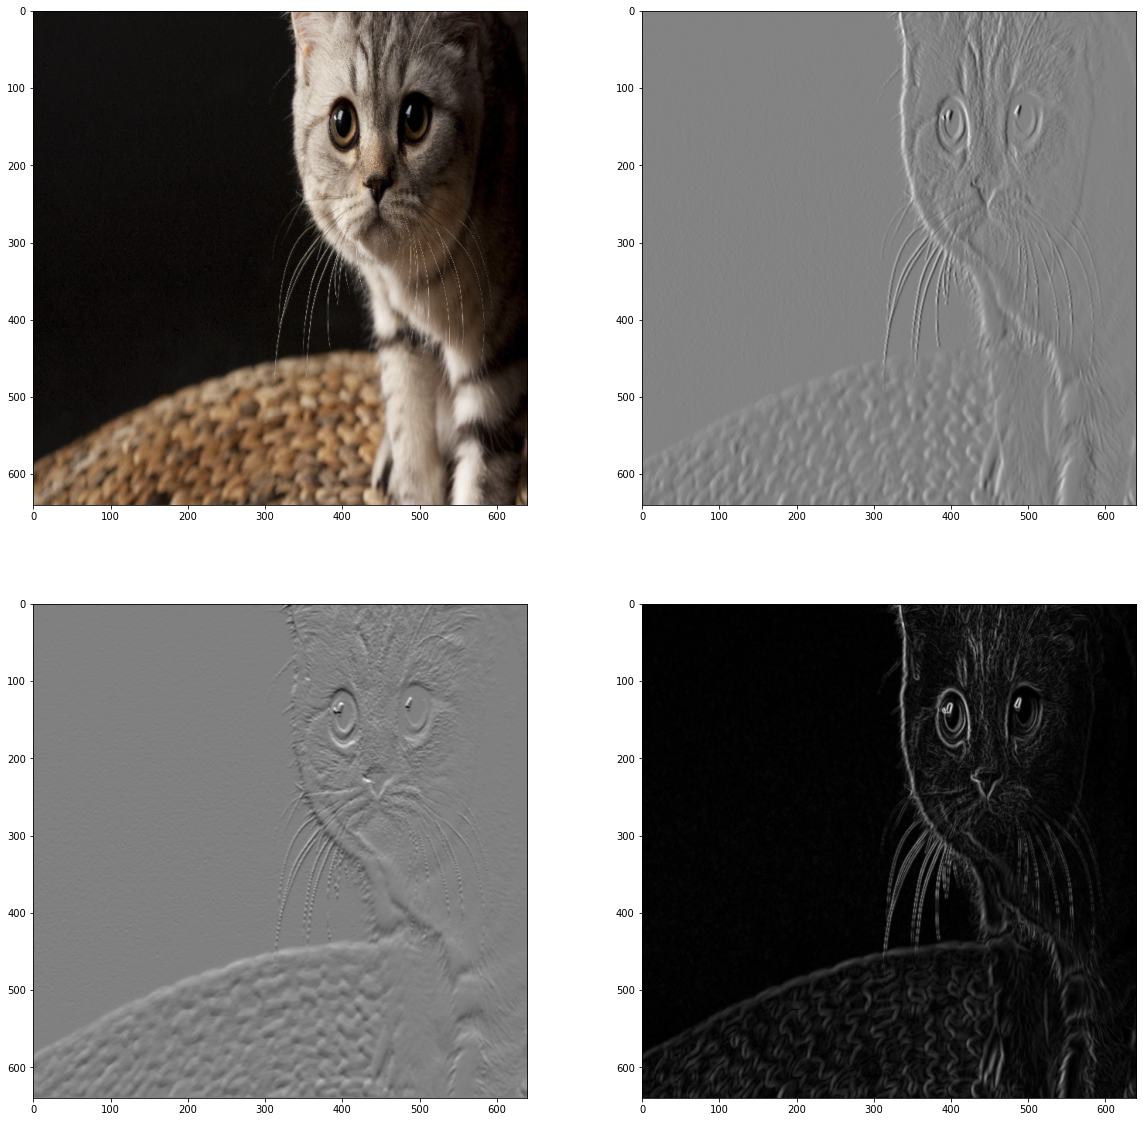

In [25]:
img = cv.imread("./ph/largeCat.jpg")
img = cv.resize(img, (640,640))
grayed = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
sobelx = cv.Sobel(grayed,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(grayed,cv.CV_64F,0,1,ksize=5)
f = plt.figure(figsize=(20,20))
f.add_subplot(221)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
f.add_subplot(222)
plt.imshow(sobelx, cmap = 'gray')
f.add_subplot(223)
plt.imshow(sobely, cmap = 'gray')
f.add_subplot(224)
sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
plt.imshow(sobel, cmap = 'gray')

#### Laplacian

На деле отличается, что под коробкой комбинирует производную по x и y, суммируя их и беря производную дважды (по собелю). Ну и еще вроде ядро другое  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


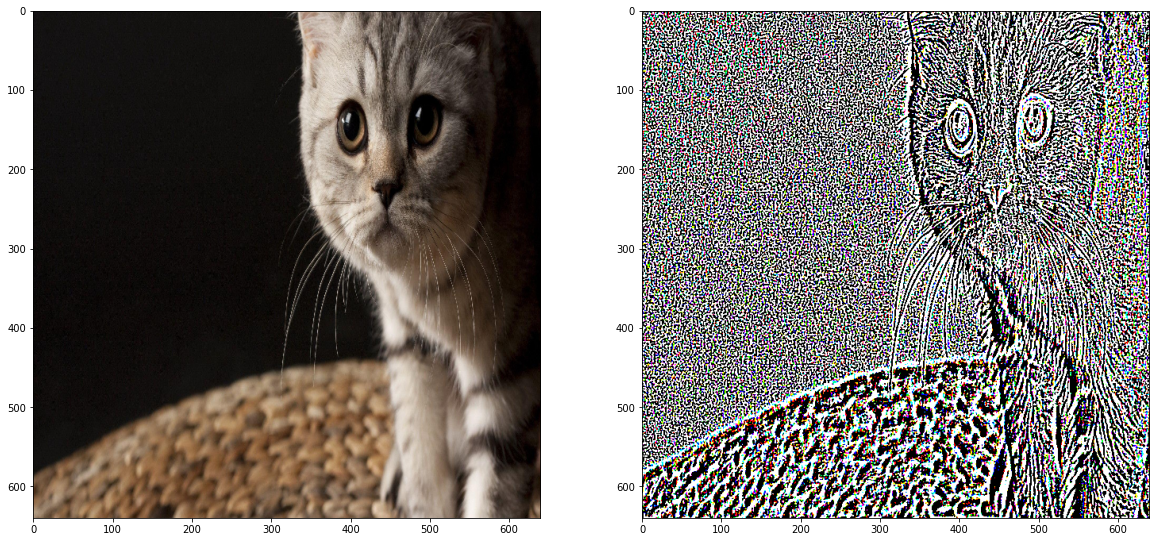

In [32]:
img = cv.imread("./ph/largeCat.jpg")
img = cv.resize(img, (640,640))
grayed = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
laplacian = cv.Laplacian(img,cv.CV_64F, ksize = 5)
f = plt.figure(figsize=(20,20))
f.add_subplot(121)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
f.add_subplot(122)
plt.imshow(laplacian, cmap = 'gray')

Рисуется прямо таки очень странно, ну да ладно

#### Canny edge detector

Как следует из название это алгоритм поиска ребер. Он делится на несколько этапов 
1. Noise reduction - поиск ребер чувствителен к шуму, так что на первом шаге происходит гауссовский блюр с ядром 5х5
2. Поиск градиента и его направления - ищется Собел производная изображения, затем находится G из Gx и Gy по формуле, данной ранее.  
Направление градиента это арктангенс (Gy/Gx)
3. Подавление немаксимумов - Оставляем только локальные максимумы. Лучше всего видно на картинке:    
![NonMaxSuppression](./info/NonMaxSuppression.png)  
Точка А - на ребре, В и С на направлении градиента. А проверяется с В и С на максимум, и проходит дальше  
Остальные точки становятся равными 0

4. Проверка на трешхолде - прошедшие ребра проверяются на "интенсивность" градиента. У нас есть мин. и  
макс значения. Все, кто больше максимума - точно ребра, все кто меньше - точно не ребра.  Те, кто лежат  
между значениями проверяются на связность с другими ребрами.

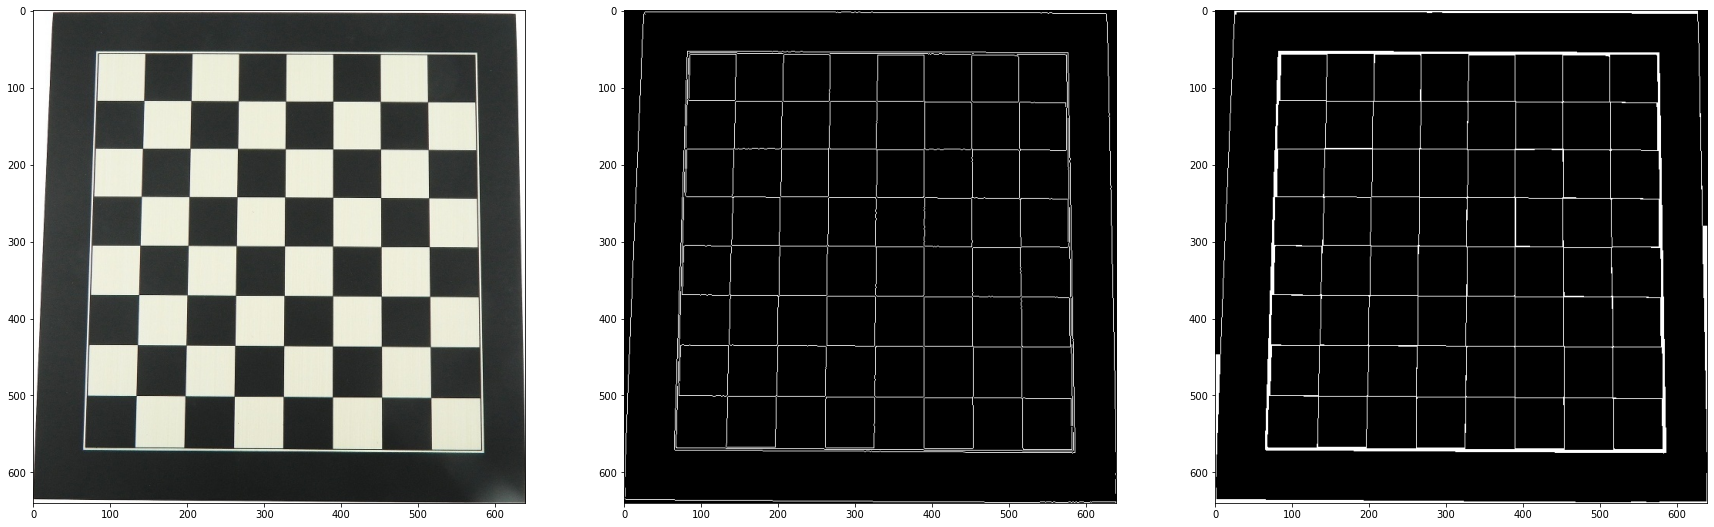

In [109]:
img = cv.imread("./ph/example.jpg")
grayed =  cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img, 100,200, L2gradient=True)
f = plt.figure(figsize=(30,20))
f.add_subplot(131)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
f.add_subplot(132)
plt.imshow(edges, cmap = 'gray')
f.add_subplot(133)
#ради закрепления материала, можно починить ребра
edges = cv.morphologyEx(edges, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT,(5,5)), iterations=3)
plt.imshow(edges, cmap = 'gray')

#### Template Matching

Я не знаю, как мне не пришло это в голову на собесе, но да. Базовый поиск шаблона, это банальная задача сравнения шаблона и изображения, как  
в свертке. Берем шаблон в качестве ядра свертки и проходимся им по изображению. В точке, где найдется максимум (минимум) по метрике, присутствует наш шаблон.  
Базовый он, потому что это все еще +/- обычная свертка: скейлинг, вращения или любые другие трансформации шаблона/шаблона на фото скорее всего приведут  
к тому, что таким способом на фото мы его найти не сможем. Кстати метрик сравнения достаточно много, для примера возьму одну.

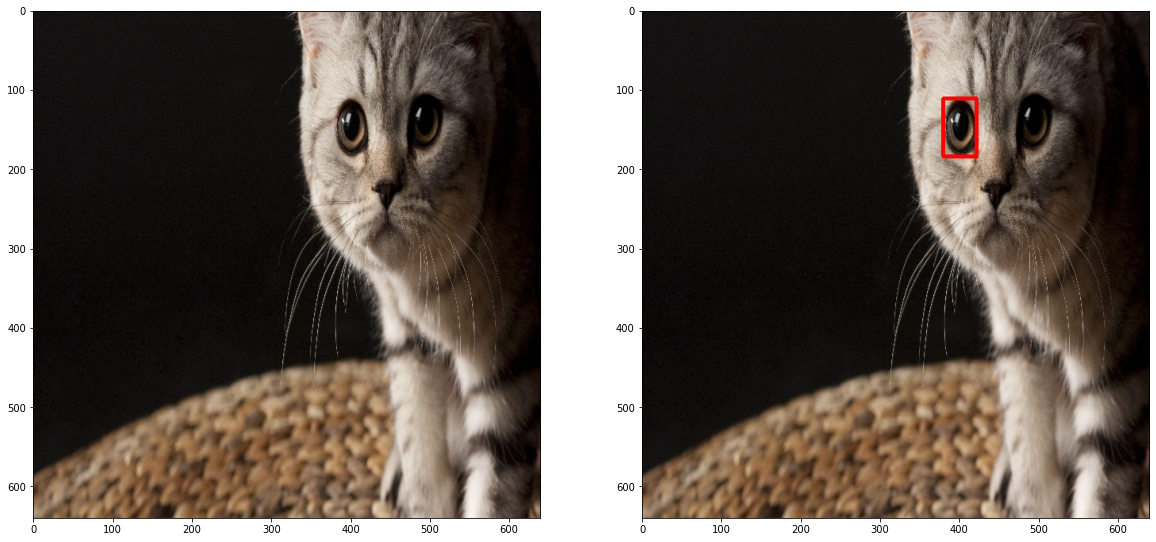

In [43]:
img = cv.imread("./ph/smallCat.jpg")
template = cv.imread("./ph/catsEye.png")
plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
f = plt.figure(figsize=(20,20))
f.add_subplot(121)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

res = cv.matchTemplate(img, template, cv.TM_CCOEFF)
_, _, _, max_loc = cv.minMaxLoc(res)
topLeftPoint = max_loc
botRightPoint = (max_loc[0] + template.shape[1], max_loc[1] + template.shape[0])
cv.rectangle(img, topLeftPoint, botRightPoint, color = (0,0,255), thickness=3)

f.add_subplot(122)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


#### Hough Line Transform

Алгоритм нахождения прямых на изображении. Идея достаточно простая. каждая прямая выражается r = x*cosO + y *cosO.  
r - расстояния от точки начала координат(перпендикуляр) и O - угол этого перпендикуляра. 
Тогда мы можем разбить наше изображение на дискретные значения этих параметров и задать их матрицей (аккумулятором)  
Далее начинаем проходиться по пикселям нашего изображения. Алгоритм требудет бинарного изображения, так что мы заранее  
знаем, какие точки ненулевые. в этих точках смотрим какие параметры дают прямую, проходящую через нее и после инкрементируем  
их в аккумуляторе. После того, как мы посмотрим все изображение, самые большие значения в матрице будут задавать параметры прямых  

Алгосу нужны бинарные изображения. Их можно получить трешхолдингом или, что лучше, Canny edge. А еще, из нериятных новостей, обычный Хаф дает  
на выходе именно найденные параметры, так что придется конструировать прямые руками через уравнение. Параметры функциии, это параметры квантования  
изображения, т.е. шаг дискретных значений, плюс пороговое значение аккумулятора

In [61]:
img = cv.imread("./ph/example.jpg")
img = cv.resize(img ,(640,640))
f = plt.figure(figsize = (20,20))
f.add_subplot(121)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
grayed = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(grayed,50,150,apertureSize = 3)

lines = cv.HoughLines(edges, 1, np.pi/180, 100)
for line in lines:
    r, o = line[0]
    a = np.cos(o)
    b = np.sin(o)
    x0 = a*r
    y0 = b*r
    x1 = np.int32(x0 + 640*(-b))
    y1 = np.int32(y0 + 640*(a))
    x2 = np.int32(x0 - 640*(-b))
    y2 = np.int32(y0 - 640*(a))
    cv.line(img,(x1,y1),(x2,y2),(0,0,255),2)
f.add_subplot(122)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


#### Probabilistic Hough Line Transform

Перебирать все точки изображения звучит как то всрато и, главное долго. Поэтому пробабалистик версия алогоса берет некоторое их подмножество   
У него два новых параметра:  
minLineLength - очевидно, что это минимальная длина линии  
maxLineGap - максимальное расстояние, между двуми прямыми, чтобы они считались одной прямой.  
А еще он сразу возвращает точки прямой, так что пользоваться ими намного проще.

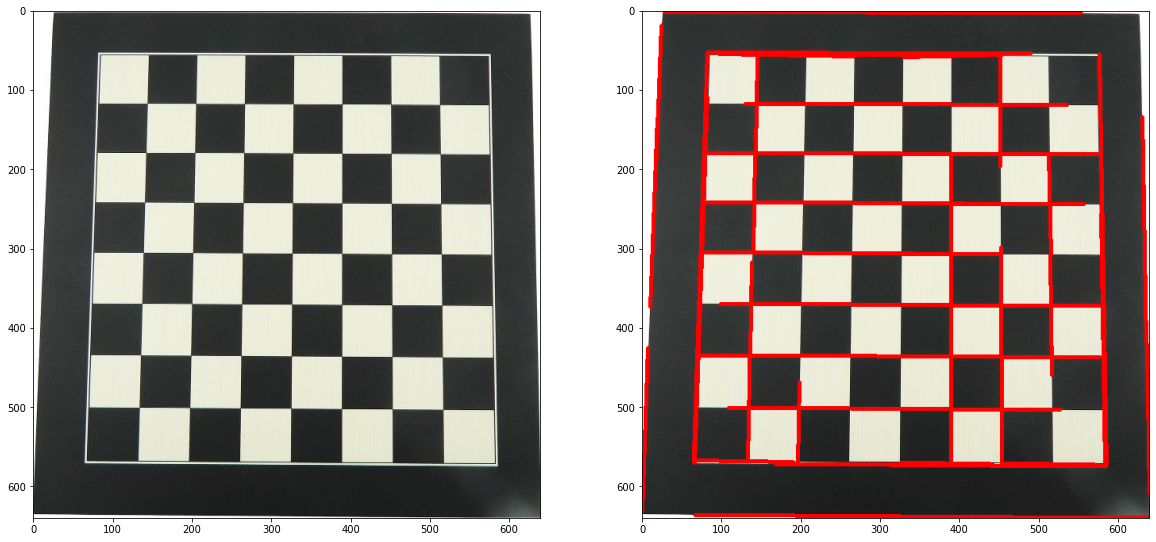

In [65]:
img = cv.imread("./ph/example.jpg")
img = cv.resize(img ,(640,640))
f = plt.figure(figsize = (20,20))
f.add_subplot(121)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
grayed = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(grayed,50,150,apertureSize = 3)

lines = cv.HoughLinesP(edges, 1, np.pi/180, 10, minLineLength=100, maxLineGap=20)
for line in lines:
    line = line[0]
    cv.line(img, (line[0],line[1]), (line[2],line[3]), color = (0,0,255), thickness= 3)
f.add_subplot(122)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


кстати можно поиграться с морфологиями, чтобы ребра детектились лучше

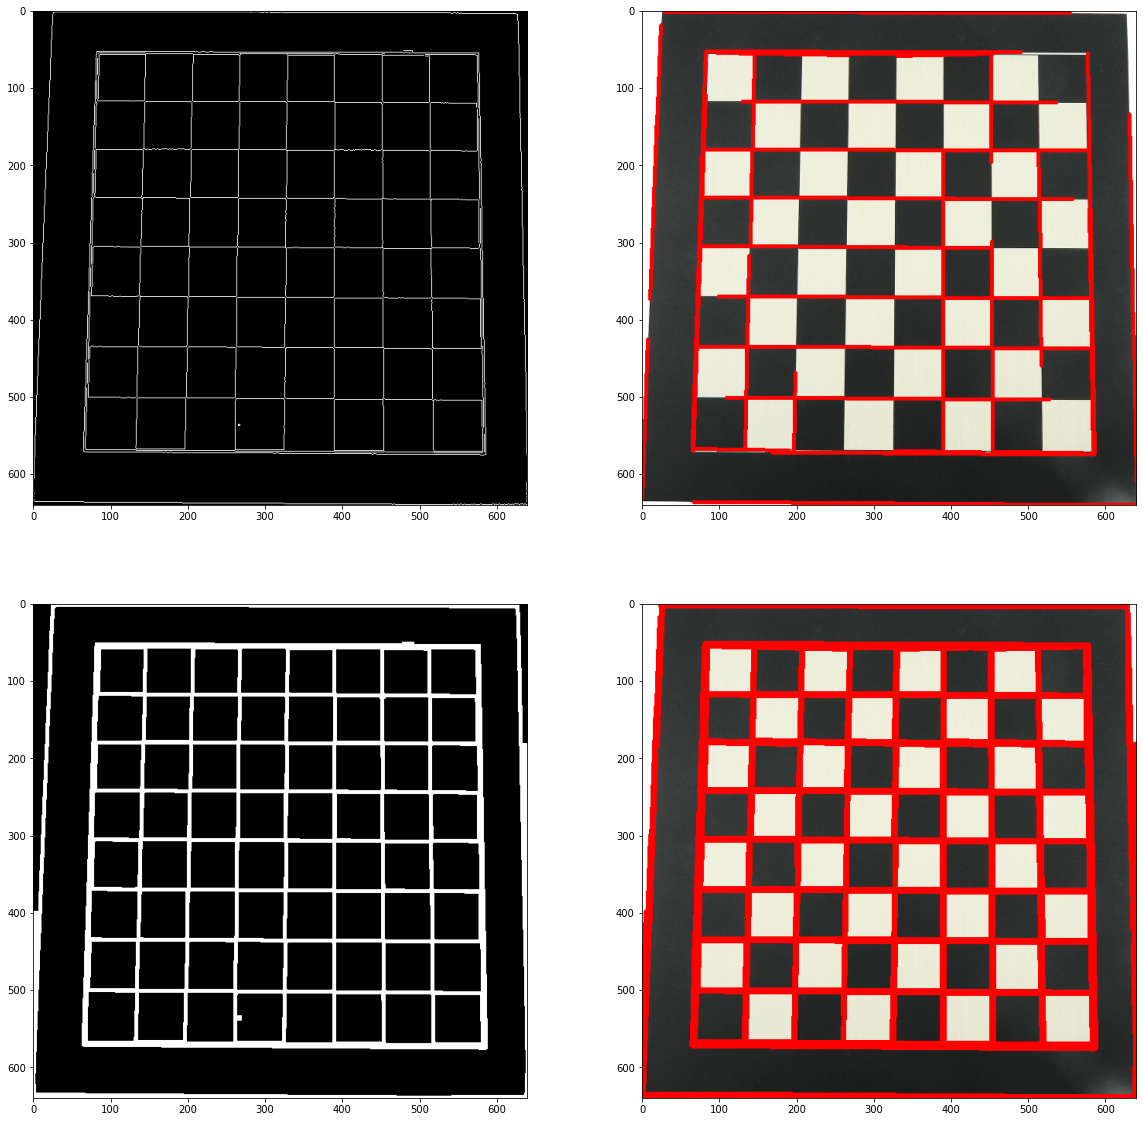

In [20]:
img = cv.imread("./ph/example.jpg")
img = cv.resize(img ,(640,640))
grayed = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(grayed,50,150,apertureSize = 3)

def drawLines(im, lines):
    for line in lines:
        line = line[0]
        cv.line(im, (line[0],line[1]), (line[2],line[3]), color = (0,0,255), thickness= 3)

lines = cv.HoughLinesP(edges, 1, np.pi/180, 10, minLineLength=100, maxLineGap=20)
im1 = img.copy()
drawLines(im1, lines)

f = plt.figure(figsize = (20,20))
f.add_subplot(221)
plt.imshow(edges, cmap = 'gray')
f.add_subplot(222)
plt.imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))

edges = cv.dilate(edges, cv.getStructuringElement(cv.MORPH_RECT, (5,5)), iterations=1)
edges = cv.morphologyEx(edges, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT,(5,5)), iterations=3)
lines = cv.HoughLinesP(edges, 1, np.pi/180, 10, minLineLength=100, maxLineGap=30)
im2 = img.copy()
drawLines(im2, lines)
f.add_subplot(223)
plt.imshow(edges, cmap = 'gray')
f.add_subplot(224)
plt.imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
